In [1]:
# Ensure the project root is in the Python path
import sys
sys.path.append('/Users/tl759k/Documents/GitHub/work/cursor-analytics')

# Activate the virtual environment (if not already activated)
# This is typically done outside the notebook, but we ensure the path is correct here
import os
os.system('source /Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/bin/activate')

# Re-import the SnowflakeHook after ensuring the path is set
from utils.snowflake_connection import SnowflakeHook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import plotly.graph_objects as go
import seaborn as sns
import statsmodels.formula.api as smf
from decimal import Decimal
import plotly.express as px


# Load the SQL query from the file
def load_query(file_path):
    with open(file_path, 'r') as file:
        query = file.read()
    snowhook = SnowflakeHook()
    df = snowhook.query_snowflake(query, method='pandas')

    # format decimal to float
    for col in df.columns:
        if df[col].dtype == 'object':
            # Check if column has any non-null values before checking type
            non_null_values = df[col].dropna()
            if len(non_null_values) > 0 and isinstance(non_null_values.iloc[0], Decimal):
                df[col] = df[col].astype(float)

    return df

### Section 1: Market Saturation

#### Data Preparation

##### U.S. Population by MSA

In [120]:
from pathlib import Path
import pandas as pd

project_root = Path('/Users/tl759k/Documents/GitHub/work/cursor-analytics/user-analysis/local_ecomm_analysis')
csv_path = project_root / 'fun_qs' / 'cbsa-est2024-agesex.csv'
assert csv_path.exists(), f'File not found: {csv_path}'
df_us_population_raw = pd.read_csv(csv_path)
df_us_population_raw.columns = df_us_population_raw.columns.str.lower()
# split by comma and take last piece, then strip whitespace


# import os; print(os.getcwd())

In [122]:

# df_us_population_msa = df_us_population[df_us_population['lsad'] == 'Metropolitan Statistical Area'] # 387 MSAs
df_us_population_310 = df_us_population_raw[df_us_population_raw['sumlev'] == 310] # 925 MSAs -- use this version to match with internal MSA list
df_us_population_310_2024 = df_us_population_310[df_us_population_310['year'] == 6] # year 6 is 2024 estimates
df_us_population_310_2024 = df_us_population_310_2024[['cbsa', 'name', 'age18plus_tot', 'age1824_tot', 'age2544_tot', 'age4564_tot', 'age65plus_tot']]
df_us_population_310_2024['cbsa'] = df_us_population_310_2024['cbsa'].astype(str)
df_us_population_310_2024.sort_values(by='age18plus_tot', ascending=False).head(10)

,cbsa,name,age18plus_tot,age1824_tot,age2544_tot,age4564_tot,age65plus_tot
1607,35620,"New York-Newark-Jersey City, NY-NJ",15805908,1676878,5549321,5009533,3570176
1349,31080,"Los Angeles-Long Beach-Anaheim, CA",10339763,1156334,3778057,3279919,2125453
437,16980,"Chicago-Naperville-Elgin, IL-IN",7406901,844918,2635081,2330857,1596045
563,19100,"Dallas-Fort Worth-Arlington, TX",6305189,778987,2482925,1987100,1056177
1025,26420,"Houston-Pasadena-The Woodlands, TX",5816478,729057,2261545,1818224,1007652
1445,33100,"Miami-Fort Lauderdale-West Palm Beach, FL",5186071,512174,1707555,1696926,1269416
1751,37980,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",5004008,564909,1740211,1551123,1147765
2405,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",5003124,554936,1859627,1616358,972203
113,12060,"Atlanta-Sandy Springs-Roswell, GA",4943007,590814,1808967,1630895,912331
269,14460,"Boston-Cambridge-Newton, MA-NH",4072057,496907,1428850,1246434,899866


In [ ]:
df_us_population_310_2024_state = df_us_population_310_2024.groupby('state').sum().reset_index()

##### Lifetime New Dx

In [143]:
df_lifetime_dx_raw = load_query('q1_lifetime_apps_and_new_dx_by_msa.sql')
# df_lifetime_dx_raw = pd.read_csv('1_lifetime_new_dx_by_msa.csv')
df_lifetime_dx_raw.columns = df_lifetime_dx_raw.columns.str.lower()
# df_lifetime_dx_raw['cbsa_code'] = df_lifetime_dx_raw['cbsa_code'].astype(int)
# df_lifetime_dx_raw['cbsa_code'] = df_lifetime_dx_raw['cbsa_code'].astype(str)
df_lifetime_dx_raw['applied_month'] = pd.to_datetime(df_lifetime_dx_raw['applied_month'])
df_lifetime_dx_raw.info()

2025-09-02 18:05:17,654 - utils.snowflake_connection - ERROR - Failed to create optimized Spark session: Java gateway process exited before sending its port number
2025-09-02 18:05:17,654 - utils.snowflake_connection - ERROR - Failed to create Spark session: Java gateway process exited before sending its port number


The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 96: CMD: bad array subscript
head: illegal line count -- -1


2025-09-02 18:05:18,222 - utils.snowflake_connection - INFO - Successfully connected to Snowflake
2025-09-02 18:05:18,223 - utils.snowflake_connection - INFO - Executing query (pandas)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69497 entries, 0 to 69496
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   cbsa_code                69416 non-null  object        
 1   msa_title                69416 non-null  object        
 2   applied_month            69497 non-null  datetime64[ns]
 3   dx_cnt_18_to_24          69497 non-null  int32         
 4   dx_cnt_25_to_44          69497 non-null  int32         
 5   dx_cnt_45_to_64          69497 non-null  int16         
 6   dx_cnt_65_above          69497 non-null  int16         
 7   dx_cnt_18plus            69497 non-null  int32         
 8   dx_cnt_18plus_cumsum     69497 non-null  int32         
 9   dx_cnt_18_to_24_cumsume  69497

##### U.S. Unemployment Rate

In [124]:
df_ur_raw = pd.read_csv('UR_updated.csv')
df_ur_raw['Area_clean'] = df_ur_raw['Area'].str.replace(r'\s*MSA$', '', regex=True)

In [125]:

df_ur = df_ur_raw.copy()
df_ur.columns = df_ur.columns.str.lower()
df_ur_grouped = df_ur.groupby(['area_clean','year','month']).agg({'civilian_labor_force': 'sum', 'employment': 'sum','unemployment': 'sum'}).reset_index()
df_ur_grouped['unemployment_rate'] = df_ur_grouped['unemployment'] / df_ur_grouped['civilian_labor_force']
df_ur_grouped

,area_clean,year,month,civilian_labor_force,employment,unemployment,unemployment_rate
0,"Abilene, TX",2021,1,80429,76293,4136,0.051424
1,"Abilene, TX",2021,2,80410,76286,4124,0.051287
2,"Abilene, TX",2021,3,80364,76299,4065,0.050582
3,"Abilene, TX",2021,4,80316,76363,3953,0.049218
4,"Abilene, TX",2021,5,80320,76505,3815,0.047498
...,...,...,...,...,...,...,...
21217,"Yuma, AZ",2025,2,99868,86984,12884,0.129010
21218,"Yuma, AZ",2025,3,100499,87242,13257,0.131912
21219,"Yuma, AZ",2025,4,101130,87631,13499,0.133482
21220,"Yuma, AZ",2025,5,101060,87408,13652,0.135088


##### MAD by MSA

In [246]:
df_mad_by_msa = load_query('q2_monthly_active_dx_by_msa.sql')
df_mad_by_msa.columns = df_mad_by_msa.columns.str.lower()
df_mad_by_msa['active_month'] = pd.to_datetime(df_mad_by_msa['active_month'])
df_mad_by_msa['active_year'] = df_mad_by_msa['active_month'].dt.year
df_mad_by_msa['active_month_num'] = df_mad_by_msa['active_month'].dt.month
df_mad_by_msa

2025-09-02 19:50:55,854 - utils.snowflake_connection - ERROR - Failed to create optimized Spark session: Java gateway process exited before sending its port number
2025-09-02 19:50:55,855 - utils.snowflake_connection - ERROR - Failed to create Spark session: Java gateway process exited before sending its port number


The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 96: CMD: bad array subscript
head: illegal line count -- -1


2025-09-02 19:50:56,091 - utils.snowflake_connection - INFO - Successfully connected to Snowflake
2025-09-02 19:50:56,091 - utils.snowflake_connection - INFO - Executing query (pandas)


,active_month,msa_title,cbsa_code,mad,shift_hours,num_delivs,hours_per_dx,delivs_per_dx,active_year,active_month_num
0,2024-01-01,"San Diego-Chula Vista-Carlsbad, CA",41740,13470,7.346203e+05,1145333.0,54.537512,85.028434,2024,1
1,2024-01-01,"Dublin, GA",20140,354,1.054455e+04,16923.0,29.786864,47.805085,2024,1
2,2024-01-01,"Lewisburg, PA",30260,249,7.721832e+03,16934.0,31.011373,68.008032,2024,1
3,2024-01-01,"San Francisco-Oakland-Fremont, CA",41860,19642,1.494952e+06,2023727.0,76.109957,103.030598,2024,1
4,2024-01-01,"Laredo, TX",29700,1114,3.738482e+04,69669.0,33.559086,62.539497,2024,1
...,...,...,...,...,...,...,...,...,...,...
17635,2025-07-01,"Athens-Clarke County, GA",12020,2076,5.999049e+04,105841.0,28.897152,50.983141,2025,7
17636,2025-07-01,"Lake Havasu City-Kingman, AZ",29420,948,3.925188e+04,73341.0,41.404933,77.363924,2025,7
17637,2025-07-01,"College Station-Bryan, TX",17780,3095,8.896275e+04,169978.0,28.744021,54.920194,2025,7
17638,2025-07-01,"Bay City, TX",13060,238,8.628689e+03,11101.0,36.254996,46.642857,2025,7


#### Analysis

##### 1. Saturation by MSA - as of June 2025

In [472]:
# df_us_population_310_2024[df_us_population_310_2024['name'].str.contains('Baltimore')]

# # Baltimore-Columbia-Towson, MD

In [473]:
# identify regulatory markets MSA:

# df_us_population_310_2024[df_us_population_310_2024['name'].str.contains('Baltimore')]
cali_msa = df_us_population_310_2024[df_us_population_310_2024['name'].str.contains('CA')]['cbsa'].unique().tolist()
ny_msa = ['35620'] # New York-Newark-Jersey City, NY-NJ, df_us_population_310_2024[df_us_population_310_2024['name'].str.contains('NY')]
seattle_msa = ['42660'] # Seattle-Tacoma-Bellevue, WA, df_us_population_310_2024[df_us_population_310_2024['name'].str.contains('Seattle')]
dc_msa = ['47900', '12580'] # Washington-Arlington-Alexandria, DC-VA-MD-WV, df_us_population_310_2024[df_us_population_310_2024['name'].str.contains('DC')]
regulatory_markets_msa = cali_msa + ny_msa + seattle_msa + dc_msa
# regulatory_markets_msa.head()

In [231]:
df_lifetime_dx = df_lifetime_dx_raw.copy()
df_msa_saturation = df_lifetime_dx.merge(df_us_population_310_2024, left_on='cbsa_code', right_on='cbsa', how='left')
df_msa_saturation = df_msa_saturation[~df_msa_saturation['age18plus_tot'].isnull()].reset_index(drop=True)
df_msa_saturation['new_dx_share_of_18plus_population'] = df_msa_saturation['dx_cnt_18plus_cumsum'] / df_msa_saturation['age18plus_tot']
df_msa_saturation['applied_month'] = pd.to_datetime(df_msa_saturation['applied_month'])
df_msa_saturation['applied_year'] = df_msa_saturation['applied_month'].dt.year
df_msa_saturation['applied_month_num'] = df_msa_saturation['applied_month'].dt.month

June_2025_snapshot = df_msa_saturation[df_msa_saturation['applied_month'] == '2025-06-01'].reset_index(drop=True)
June_2025_snapshot = June_2025_snapshot[['cbsa_code', 'msa_title', 'age18plus_tot', 'dx_cnt_18plus_cumsum', 'new_dx_share_of_18plus_population']]

June_2025_snapshot

,cbsa_code,msa_title,age18plus_tot,dx_cnt_18plus_cumsum,new_dx_share_of_18plus_population
0,19580,"Defiance, OH",30126.0,1102,0.036580
1,26020,"Hobbs, NM",53653.0,2393,0.044601
2,29180,"Lafayette, LA",317496.0,13167,0.041471
3,11660,"Arkadelphia, AR",16593.0,659,0.039716
4,27020,"Iron Mountain, MI-WI",24998.0,558,0.022322
...,...,...,...,...,...
910,19810,"Detroit Lakes, MN",27481.0,412,0.014992
911,34460,"Mount Sterling, KY",36965.0,1014,0.027431
912,40300,"Rochelle, IL",40183.0,396,0.009855
913,18220,"Connersville, IN",18220.0,661,0.036279


In [232]:
June_2025_snapshot = June_2025_snapshot[~June_2025_snapshot['cbsa_code'].isin(['13700', '44860', '11680'])]

In [233]:
June_2025_snapshot.sort_values(by='new_dx_share_of_18plus_population', ascending=False).head(10)

,cbsa_code,msa_title,age18plus_tot,dx_cnt_18plus_cumsum,new_dx_share_of_18plus_population
785,18300,"Coos Bay-North Bend, OR",53449.0,7574,0.141705
292,25980,"Hinesville, GA",64092.0,7418,0.115740
433,37060,"Oxford, MS",58994.0,6653,0.112774
68,14380,"Boone, NC",48580.0,5195,0.106937
602,44260,"Starkville, MS",50458.0,5241,0.103869
735,29660,"Laramie, WY",33432.0,3246,0.097093
806,45880,"Town of Pecos, TX",8696.0,831,0.095561
243,40820,"Ruston, LA",38751.0,3656,0.094346
362,39420,"Pullman, WA",40828.0,3797,0.093000
8,44340,"Statesboro, GA",76952.0,6951,0.090329


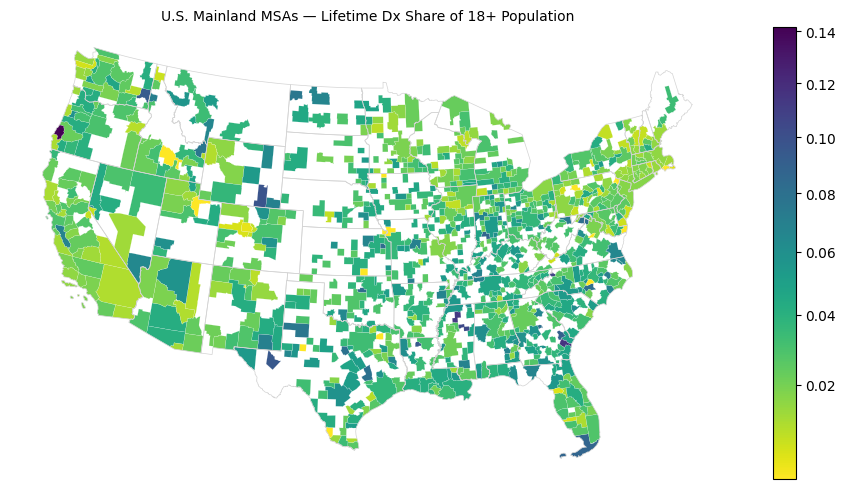

NaNs remaining: 0
Min value: 0.0001


In [237]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm

# -----------------------------
# Inputs
# -----------------------------
df = June_2025_snapshot.copy()
df['cbsa_code'] = df['cbsa_code'].astype(str).str.zfill(5)  # ensure 5-digit codes

# Load CBSA polygons (MSA+µSA) from local file
cbsa = gpd.read_file("./tl_2024_us_cbsa/tl_2024_us_cbsa.shp")
cbsa['CBSAFP'] = cbsa['CBSAFP'].astype(str).str.zfill(5)

# -----------------------------
# Keep only MSAs and mainland
# -----------------------------
# if 'LSAD' in cbsa.columns:
#     cbsa = cbsa[cbsa['LSAD'] == 'M1'].copy()

cbsa_ll = cbsa.to_crs(4326)
rep_pts = cbsa_ll.geometry.representative_point()
mainland_mask = rep_pts.x.between(-125, -66) & rep_pts.y.between(24, 50)
cbsa_mainland = cbsa.loc[mainland_mask].copy()
cbsa_mainland = cbsa_mainland.to_crs(5070)
cbsa_mainland["geometry"] = cbsa_mainland.geometry.simplify(tolerance=1000, preserve_topology=True)

# -----------------------------
# Join your metric
# -----------------------------
merged = cbsa_mainland.merge(
    df[['cbsa_code', 'new_dx_share_of_18plus_population']],
    left_on="CBSAFP",
    right_on="cbsa_code",
    how="left"
)

merged['new_dx_share_of_18plus_population'] = merged['new_dx_share_of_18plus_population'].fillna(0.0001)
# merged['new_dx_share_of_18plus_population'] = np.log(merged['new_dx_share_of_18plus_population'])
# -----------------------------
# Add light U.S. state boundaries
# -----------------------------
states = gpd.read_file("./tl_2024_us_state/tl_2024_us_state.shp")

# Filter mainland states
states = states.to_crs(4326)
rep_pts_states = states.geometry.representative_point()
mainland_states_mask = rep_pts_states.x.between(-125, -66) & rep_pts_states.y.between(24, 50)
states_mainland = states.loc[mainland_states_mask].copy()

# Reproject and simplify
states_mainland = states_mainland.to_crs(5070)
states_mainland["geometry"] = states_mainland.geometry.simplify(tolerance=1000, preserve_topology=True)

# -----------------------------
# Plot
# -----------------------------
fig, ax = plt.subplots(figsize=(10, 5))

# Base: state boundaries
states_mainland.boundary.plot(ax=ax, color="lightgray", linewidth=0.5)

norm = PowerNorm(gamma=0.8, vmin=merged['new_dx_share_of_18plus_population'].min(),
                             vmax=merged['new_dx_share_of_18plus_population'].max())

merged.plot(
    ax=ax,
    column="new_dx_share_of_18plus_population",
    cmap="viridis_r",
    edgecolor="white",
    linewidth=0.1,
    legend=True,
    norm=norm
)

# Final touches
ax.set_title("U.S. Mainland MSAs — Lifetime Dx Share of 18+ Population", fontsize=10, pad=5)
ax.set_aspect("equal")
ax.axis("off")
plt.tight_layout()
plt.show()

print("NaNs remaining:", merged['new_dx_share_of_18plus_population'].isna().sum())
print("Min value:", merged['new_dx_share_of_18plus_population'].min())



In [192]:
top_msa = df_us_population_310_2024.sort_values(by='age18plus_tot', ascending=False).head(500)
top_msa

df_ur_june_2025 = df_ur_grouped[(df_ur_grouped['month'] == 6) & (df_ur_grouped['year'] == 2025)]
check = top_msa.merge(df_ur_june_2025, left_on='name', right_on='area_clean', how='inner')
check
## regulatory markets:
## 35620 - New York, Seattle, California

,cbsa,name,age18plus_tot,age1824_tot,age2544_tot,age4564_tot,age65plus_tot,area_clean,year,month,civilian_labor_force,employment,unemployment,unemployment_rate
0,35620,"New York-Newark-Jersey City, NY-NJ",15805908,1676878,5549321,5009533,3570176,"New York-Newark-Jersey City, NY-NJ",2025,6,10225989,9783286,442703,0.043292
1,31080,"Los Angeles-Long Beach-Anaheim, CA",10339763,1156334,3778057,3279919,2125453,"Los Angeles-Long Beach-Anaheim, CA",2025,6,6707241,6354266,352975,0.052626
2,16980,"Chicago-Naperville-Elgin, IL-IN",7406901,844918,2635081,2330857,1596045,"Chicago-Naperville-Elgin, IL-IN",2025,6,5018250,4774379,243871,0.048597
3,19100,"Dallas-Fort Worth-Arlington, TX",6305189,778987,2482925,1987100,1056177,"Dallas-Fort Worth-Arlington, TX",2025,6,4551219,4379552,171667,0.037719
4,26420,"Houston-Pasadena-The Woodlands, TX",5816478,729057,2261545,1818224,1007652,"Houston-Pasadena-The Woodlands, TX",2025,6,3891620,3725716,165904,0.042631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,21300,"Elmira, NY",64365,6635,20172,20243,17315,"Elmira, NY",2025,6,35326,34075,1251,0.035413
378,25980,"Hinesville, GA",64092,10231,28912,15295,9654,"Hinesville, GA",2025,6,30992,29769,1223,0.039462
379,16220,"Casper, WY",62029,6396,22284,18615,14734,"Casper, WY",2025,6,41637,40250,1387,0.033312
380,33500,"Minot, ND",57933,8193,22304,15323,12113,"Minot, ND",2025,6,40227,39232,995,0.024735


##### 2. Top MSA w/ Highest YoY Growth in New Dx

In [510]:
df = df_msa_saturation.copy()
df = df[~df['msa_title'].isin(regulatory_markets_msa)]

df['date'] = pd.to_datetime(df['applied_month']).dt.to_period('M').dt.to_timestamp()  # 归一为月初日期
df['market'] = df['msa_title']
df['users'] = df['dx_cnt_18plus_cumsum'] # dx_cnt_18plus_cumsum

cutoff_year = 2025
start_month = 1
cutoff_month = 6

this_year_start = pd.Timestamp(year = cutoff_year, month=start_month, day=1)
this_year_end   = pd.Timestamp(year = cutoff_year, month=cutoff_month, day=1)

last_year_start = pd.Timestamp(year= cutoff_year - 1, month = start_month, day = 1)
last_year_end   = pd.Timestamp(year= cutoff_year - 1, month = cutoff_month, day=1)

# l2_year_start = pd.Timestamp(year= cutoff_year - 2, month = 4, day = 1)
# l2_year_end   = pd.Timestamp(year= cutoff_year - 2, month = cutoff_month, day=1)


ytd_this = df[(df['date']>=this_year_start) & (df['date']<=this_year_end)]
ytd_this = ytd_this[(ytd_this['users'] >ytd_this['users'].min()) & (ytd_this['users'] < ytd_this['users'].max())]
ytd_this = ytd_this.groupby('market', as_index=False)['users'].mean().rename(columns={'users':'users_ytd_this'})

ytd_last = df[(df['date']>=last_year_start) & (df['date']<=last_year_end)]
ytd_last = ytd_last[(ytd_last['users'] >ytd_last['users'].min()) & (ytd_last['users'] < ytd_last['users'].max())]
ytd_last = ytd_last.groupby('market', as_index=False)['users'].mean().rename(columns={'users':'users_ytd_last'})

# ytd_l2 = (df[(df['date']>=l2_year_start) & (df['date']<=l2_year_end)].groupby('market', as_index=False)['users'].sum().rename(columns={'users':'users_ytd_last'}))


ytd = ytd_this.merge(ytd_last, on='market', how='left')
ytd['ytd_yoy'] = np.where(ytd['users_ytd_last'] > 0, ytd['users_ytd_this'] / ytd['users_ytd_last'] - 1, np.nan)
# ytd['ytd_l2yoy'] = np.where(ytd['users_ytd_l2'] > 0, ytd['users_ytd_this'] / ytd['users_ytd_l2'] - 1, np.nan)
ytd_ranked = ytd.sort_values('ytd_yoy', ascending=False)

reg_markets_msa = ['Washington-Arlington-Alexandria, DC-VA-MD-WV', 'Baltimore-Columbia-Towson, MD']
ytd_ranked = ytd_ranked[~ytd_ranked['market'].isin(reg_markets_msa)]

top_10_msa = ytd_ranked[ytd_ranked['users_ytd_this'] > 50000].head(10).reset_index(drop=True) # 100000

top_10_msa

,market,users_ytd_this,users_ytd_last,ytd_yoy
0,"Houston-Pasadena-The Woodlands, TX",205203.833333,152624.500000,0.344501
1,"Las Vegas-Henderson-North Las Vegas, NV",115437.666667,89014.666667,0.296839
2,"Memphis, TN-MS-AR",52388.500000,40499.666667,0.293554
3,"Minneapolis-St. Paul-Bloomington, MN-WI",51267.166667,39985.666667,0.282139
4,"Orlando-Kissimmee-Sanford, FL",93340.333333,72900.166667,0.280386
5,"Dallas-Fort Worth-Arlington, TX",198674.500000,155353.000000,0.278858
6,"Detroit-Warren-Dearborn, MI",88956.833333,70379.000000,0.263968
7,"Nashville-Davidson--Murfreesboro--Franklin, TN",74933.500000,59656.000000,0.256093
8,"Miami-Fort Lauderdale-West Palm Beach, FL",140663.000000,112014.166667,0.255761
9,"Jacksonville, FL",64062.166667,51071.666667,0.254358


In [511]:
top_10_msa.sort_values('users_ytd_this', ascending=False, inplace = True)

top_10_msa.head(10)

,market,users_ytd_this,users_ytd_last,ytd_yoy
0,"Houston-Pasadena-The Woodlands, TX",205203.833333,152624.500000,0.344501
5,"Dallas-Fort Worth-Arlington, TX",198674.500000,155353.000000,0.278858
8,"Miami-Fort Lauderdale-West Palm Beach, FL",140663.000000,112014.166667,0.255761
1,"Las Vegas-Henderson-North Las Vegas, NV",115437.666667,89014.666667,0.296839
4,"Orlando-Kissimmee-Sanford, FL",93340.333333,72900.166667,0.280386
6,"Detroit-Warren-Dearborn, MI",88956.833333,70379.000000,0.263968
7,"Nashville-Davidson--Murfreesboro--Franklin, TN",74933.500000,59656.000000,0.256093
9,"Jacksonville, FL",64062.166667,51071.666667,0.254358
2,"Memphis, TN-MS-AR",52388.500000,40499.666667,0.293554
3,"Minneapolis-St. Paul-Bloomington, MN-WI",51267.166667,39985.666667,0.282139


In [491]:

top_10_msa.sort_values('users_ytd_this', ascending=False, inplace = True)

msa_order = top_10_msa['market'].tolist()

# lock the order into the dataframe (optional but helpful)
df = df[df['date'] >= '2024-01-01']
df = df[df['date'] <= '2025-06-01']
df['msa_title'] = pd.Categorical(df['msa_title'], categories=msa_order, ordered=True)

# plot: one colored line per MSA with legend ordered by msa_order
fig = px.line(
    df,
    x='applied_month',
    y='dx_cnt_18plus_cumsum',
    color='msa_title',
    markers=True,
    labels={'applied_month': 'Month', 'dx_cnt_18plus_cumsum': 'Rate', 'msa_title': 'MSA'},
    title='Top 10 MSAs with Highest Growth in Lifetime Dx (Jan 2024 – Jun 2025)',
    category_orders={'msa_title': msa_order}  # <- legend & color order
)

# keep default legend trace order (don’t reverse)
fig.update_layout(legend_title_text='MSA', hovermode='x unified', legend=dict(traceorder='normal'))

fig.update_xaxes(tickformat='%Y-%m', rangeslider_visible=False)
fig.update_yaxes(title_text='Rate')
fig.update_traces(hovertemplate='%{fullData.name}<br>%{x|%b %Y}: %{y:.2f}')
fig.show()


##### 3. Meta Dataset

In [737]:
df_mad_by_msa_raw = load_query('q2_monthly_active_dx_by_msa.sql')
df_mad_by_msa_raw['active_month'] = pd.to_datetime(df_mad_by_msa_raw['active_month'])
df_mad_by_msa_raw['cbsa_code'] = df_mad_by_msa_raw['cbsa_code'].astype(str)
df_mad_by_msa = df_mad_by_msa_raw[['active_month','cbsa_code','mad','shift_hours','num_delivs','hours_per_dx','delivs_per_dx','mad_18_to_24','shift_hours_18_to_24','num_delivs_18_to_24','hours_per_dx_18_to_24','delivs_per_dx_18_to_24']]

2025-09-03 09:07:28,283 - utils.snowflake_connection - ERROR - Failed to create optimized Spark session: Java gateway process exited before sending its port number
2025-09-03 09:07:28,284 - utils.snowflake_connection - ERROR - Failed to create Spark session: Java gateway process exited before sending its port number


The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 96: CMD: bad array subscript
head: illegal line count -- -1


2025-09-03 09:07:28,663 - utils.snowflake_connection - INFO - Successfully connected to Snowflake
2025-09-03 09:07:28,664 - utils.snowflake_connection - INFO - Executing query (pandas)


In [738]:
df_msa_saturation_join = df_msa_saturation.merge(df_mad_by_msa, left_on= ['applied_month','cbsa_code'], right_on=['active_month','cbsa_code'], how='inner')

In [816]:
df_msa_saturation_ur = df_msa_saturation_join.merge(df_ur_grouped, left_on= ['applied_year','applied_month_num','msa_title'], right_on=['year','month','area_clean'], how='inner')
df_msa_saturation_ur = df_msa_saturation_ur[['msa_title','cbsa_code','applied_month' ,'applied_year','applied_month_num','dx_cnt_18plus', 'dx_cnt_18plus_cumsum','dx_cnt_18_to_24', 'dx_cnt_18_to_24_cumsume','age18plus_tot', 'age1824_tot','civilian_labor_force','new_dx_share_of_18plus_population','unemployment_rate'
,'mad','shift_hours','num_delivs','hours_per_dx','delivs_per_dx','mad_18_to_24','shift_hours_18_to_24','num_delivs_18_to_24','hours_per_dx_18_to_24','delivs_per_dx_18_to_24']]

df_msa_saturation_ur['new_dx_18to24_share_of_18to24_population'] = df_msa_saturation_ur['dx_cnt_18_to_24_cumsume'] / df_msa_saturation_ur['age1824_tot']
df_msa_saturation_ur['new_dx_18to24_share_of_18plus_population'] = df_msa_saturation_ur['dx_cnt_18_to_24_cumsume'] / df_msa_saturation_ur['age18plus_tot']
df_msa_saturation_ur.sort_values(by='new_dx_share_of_18plus_population', ascending=False)

,msa_title,cbsa_code,applied_month,applied_year,applied_month_num,dx_cnt_18plus,dx_cnt_18plus_cumsum,dx_cnt_18_to_24,dx_cnt_18_to_24_cumsume,age18plus_tot,...,num_delivs,hours_per_dx,delivs_per_dx,mad_18_to_24,shift_hours_18_to_24,num_delivs_18_to_24,hours_per_dx_18_to_24,delivs_per_dx_18_to_24,new_dx_18to24_share_of_18to24_population,new_dx_18to24_share_of_18plus_population
2105,"Hinesville, GA",25980,2025-06-01,2025,6,119,7418,45,2083,64092.0,...,78657.0,28.070965,49.940952,390.0,6944.280000,11763.0,17.805846,30.161538,0.203597,0.032500
2104,"Hinesville, GA",25980,2025-05-01,2025,5,109,7299,34,2038,64092.0,...,78991.0,27.335417,49.836593,391.0,6624.146111,12317.0,16.941550,31.501279,0.199199,0.031798
2103,"Hinesville, GA",25980,2025-04-01,2025,4,135,7190,54,2004,64092.0,...,72308.0,25.533324,48.922869,357.0,6224.094444,12129.0,17.434438,33.974790,0.195875,0.031268
2102,"Hinesville, GA",25980,2025-03-01,2025,3,98,7055,34,1950,64092.0,...,77756.0,28.807915,57.342183,347.0,7213.845833,13180.0,20.789181,37.982709,0.190597,0.030425
2101,"Hinesville, GA",25980,2025-02-01,2025,2,83,6957,23,1916,64092.0,...,66590.0,27.379954,51.620155,315.0,5420.854167,10556.0,17.209061,33.511111,0.187274,0.029895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1981,"Homosassa Springs, FL",26140,2024-02-01,2024,2,6,405,0,79,145497.0,...,6320.0,33.777071,51.382114,12.0,91.087778,150.0,7.590648,12.500000,0.008896,0.000543
1980,"Homosassa Springs, FL",26140,2024-01-01,2024,1,4,399,2,79,145497.0,...,6195.0,39.650270,55.312500,13.0,197.893056,309.0,15.222543,23.769231,0.008896,0.000543
6371,"St. Joseph, MO-KS",41140,2024-10-01,2024,10,1,4,1,1,92873.0,...,51.0,26.166111,51.000000,1.0,26.166111,51.0,26.166111,51.000000,0.000095,0.000011
6370,"St. Joseph, MO-KS",41140,2024-02-01,2024,2,1,3,0,0,92873.0,...,262.0,60.110416,131.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000


In [817]:
df_msa_saturation_ur.to_csv('df_msa_saturation_ur.csv', index=False)

##### 4. UR y/y vs New Dx y/y

In [820]:
def calc_yoy(df, metric):

    cutoff_year = 2025
    start_month = 1
    cutoff_month = 6

    this_year_start = pd.Timestamp(year = cutoff_year, month=start_month, day=1)
    this_year_end   = pd.Timestamp(year = cutoff_year, month=cutoff_month, day=1)

    last_year_start = pd.Timestamp(year= cutoff_year - 1, month = start_month, day = 1)
    last_year_end   = pd.Timestamp(year= cutoff_year - 1, month = cutoff_month, day=1)

    # l2_year_start = pd.Timestamp(year= cutoff_year - 2, month = 4, day = 1)
    # l2_year_end   = pd.Timestamp(year= cutoff_year - 2, month = cutoff_month, day=1)


    ytd_this = df[(df['date']>=this_year_start) & (df['date']<=this_year_end)]
    ytd_this = ytd_this[(ytd_this['users'] >ytd_this['users'].min()) & (ytd_this['users'] < ytd_this['users'].max())]
    ytd_this = ytd_this.groupby('market', as_index=False)['users'].mean().rename(columns={'users':'users_ytd_this'})

    ytd_last = df[(df['date']>=last_year_start) & (df['date']<=last_year_end)]
    ytd_last = ytd_last[(ytd_last['users'] >ytd_last['users'].min()) & (ytd_last['users'] < ytd_last['users'].max())]
    ytd_last = ytd_last.groupby('market', as_index=False)['users'].mean().rename(columns={'users':'users_ytd_last'})

    # ytd_l2 = (df[(df['date']>=l2_year_start) & (df['date']<=l2_year_end)].groupby('market', as_index=False)['users'].sum().rename(columns={'users':'users_ytd_last'}))


    ytd = ytd_this.merge(ytd_last, on='market', how='left')
    ytd['ytd_yoy'] = np.where(ytd['users_ytd_last'] > 0, ytd['users_ytd_this'] / ytd['users_ytd_last'] - 1, np.nan)
    # ytd['ytd_l2yoy'] = np.where(ytd['users_ytd_l2'] > 0, ytd['users_ytd_this'] / ytd['users_ytd_l2'] - 1, np.nan)
    ytd_ranked = ytd.sort_values('ytd_yoy', ascending=False)

    # top_10_msa = ytd_ranked[ytd_ranked['users_ytd_this'] > 1000].head(10).reset_index(drop=True) # 100000

    # top_10_msa
    # new_dx_share_of_18plus_population_yoy = ytd_ranked.copy()

    return ytd_ranked

In [821]:
# X: Unemployment Rate
df = df_msa_saturation_ur.copy()
df = df[~df['cbsa_code'].isin(regulatory_markets_msa)]
df['date'] = pd.to_datetime(df['applied_month']).dt.to_period('M').dt.to_timestamp()
df['market'] = df['msa_title']
df['users'] = df['unemployment_rate'] # dx_cnt_18plus_cumsum

ur_yoy = calc_yoy(df, 'unemployment_rate')

In [822]:
# Y1.1: lifetime new dx cumsum by MSA
df = df_msa_saturation_ur.copy()
df = df[~df['cbsa_code'].isin(regulatory_markets_msa)]
df['date'] = pd.to_datetime(df['applied_month']).dt.to_period('M').dt.to_timestamp()
df['market'] = df['msa_title']
df['users'] = df['dx_cnt_18plus_cumsum'] # dx_cnt_18plus_cumsum

new_dx_yoy = calc_yoy(df, 'dx_cnt_18plus_cumsum')

In [823]:
# Y1.2: lifetime new dx age 18-24 cumsum by MSA
df = df_msa_saturation_ur.copy()
df = df[~df['cbsa_code'].isin(regulatory_markets_msa)]
df['date'] = pd.to_datetime(df['applied_month']).dt.to_period('M').dt.to_timestamp()
df['market'] = df['msa_title']
df['users'] = df['dx_cnt_18_to_24_cumsume'] # dx_cnt_18plus_cumsum

new_dx_18to24_yoy = calc_yoy(df, 'dx_cnt_18_to_24_cumsume')

In [824]:
# Y2.1: lifetime new dx share of population (age 18+)
df = df_msa_saturation_ur.copy()
df = df[~df['cbsa_code'].isin(regulatory_markets_msa)]
df['date'] = pd.to_datetime(df['applied_month']).dt.to_period('M').dt.to_timestamp()
df['market'] = df['msa_title']
df['users'] = df['new_dx_share_of_18plus_population'] # dx_cnt_18plus_cumsum

new_dx_share_of_18plus_population_yoy = calc_yoy(df, 'new_dx_share_of_18plus_population')

In [825]:
# Y2.2: lifetime new dx share of population (age 18-24)
df = df_msa_saturation_ur.copy()
df = df[~df['cbsa_code'].isin(regulatory_markets_msa)]
df['date'] = pd.to_datetime(df['applied_month']).dt.to_period('M').dt.to_timestamp()
df['market'] = df['msa_title']
df['users'] = df['new_dx_18to24_share_of_18to24_population'] # dx_cnt_18plus_cumsum

new_dx_18to24_share_of_18to24_population_yoy = calc_yoy(df, 'new_dx_18to24_share_of_18to24_population')

In [826]:
# Y3.1: total shift hours
df = df_msa_saturation_ur.copy()
df = df[~df['cbsa_code'].isin(regulatory_markets_msa)]
df['date'] = pd.to_datetime(df['applied_month']).dt.to_period('M').dt.to_timestamp()
df['market'] = df['msa_title']
df['users'] = df['shift_hours'] # dx_cnt_18plus_cumsum

total_shift_hours_yoy = calc_yoy(df, 'shift_hours')

In [827]:
# Y3.2: total shift hours age 18-24
df = df_msa_saturation_ur.copy()
df = df[~df['cbsa_code'].isin(regulatory_markets_msa)]
df['date'] = pd.to_datetime(df['applied_month']).dt.to_period('M').dt.to_timestamp()
df['market'] = df['msa_title']
df['users'] = df['shift_hours_18_to_24'] # dx_cnt_18plus_cumsum

total_shift_hours_18to24_yoy = calc_yoy(df, 'shift_hours_18_to_24')

In [828]:
# Y4.1: Hours per Dx
df = df_msa_saturation_ur.copy()
df = df[~df['cbsa_code'].isin(regulatory_markets_msa)]
df['date'] = pd.to_datetime(df['applied_month']).dt.to_period('M').dt.to_timestamp()
df['market'] = df['msa_title']
df['users'] = df['hours_per_dx'] # dx_cnt_18plus_cumsum

hours_per_dx_yoy = calc_yoy(df, 'hours_per_dx')

In [829]:
# Y4.2: Hours per Dx age 18-24
df = df_msa_saturation_ur.copy()
df = df[~df['cbsa_code'].isin(regulatory_markets_msa)]
df['date'] = pd.to_datetime(df['applied_month']).dt.to_period('M').dt.to_timestamp()
df['market'] = df['msa_title']
df['users'] = df['hours_per_dx_18_to_24'] # dx_cnt_18plus_cumsum

hours_per_dx_18to24_yoy = calc_yoy(df, 'hours_per_dx_18_to_24')

In [830]:
ur_yoy.rename(columns={'users_ytd_this': 'unemployment_rate_TY', 'users_ytd_last': 'unemployment_rate_LY', 'ytd_yoy':'unemployment_rate_yoy'}, inplace=True)

new_dx_yoy.rename(columns={'users_ytd_this': 'new_dx_TY', 'users_ytd_last': 'new_dx_LY', 'ytd_yoy':'new_dx_yoy'}, inplace=True)
new_dx_18to24_yoy.rename(columns={'users_ytd_this': 'new_dx_18_to_24_TY', 'users_ytd_last': 'new_dx_18_to_24_LY', 'ytd_yoy':'new_dx_18_to_24_yoy'}, inplace=True)

new_dx_share_of_18plus_population_yoy.rename(columns={'users_ytd_this': 'share_of_18plus_TY', 'users_ytd_last': 'share_of_18plus_LY', 'ytd_yoy':'share_of_18plus_yoy'}, inplace=True)
new_dx_18to24_share_of_18to24_population_yoy.rename(columns={'users_ytd_this': '18to24_share_of_18to24_TY', 'users_ytd_last': '18to24_share_of_18to24_LY', 'ytd_yoy':'18to24_share_of_18to24_yoy'}, inplace=True)

total_shift_hours_yoy.rename(columns={'users_ytd_this': 'total_shift_hours_TY', 'users_ytd_last': 'total_shift_hours_LY', 'ytd_yoy':'total_shift_hours_yoy'}, inplace=True)
total_shift_hours_18to24_yoy.rename(columns={'users_ytd_this': 'total_shift_hours_18_to_24_TY', 'users_ytd_last': 'total_shift_hours_18_to_24_LY', 'ytd_yoy':'total_shift_hours_18_to_24_yoy'}, inplace=True)

hours_per_dx_yoy.rename(columns={'users_ytd_this': 'hours_per_dx_TY', 'users_ytd_last': 'hours_per_dx_LY', 'ytd_yoy':'hours_per_dx_yoy'}, inplace=True)
hours_per_dx_18to24_yoy.rename(columns={'users_ytd_this': 'hours_per_dx_18_to_24_TY', 'users_ytd_last': 'hours_per_dx_18_to_24_LY', 'ytd_yoy':'hours_per_dx_18_to_24_yoy'}, inplace=True)

In [831]:
df_all_yoy = ur_yoy.merge(new_dx_yoy, on='market', how='left')
df_all_yoy = df_all_yoy.merge(new_dx_18to24_yoy, on='market', how='left')

df_all_yoy = df_all_yoy.merge(new_dx_share_of_18plus_population_yoy, on='market', how='left')
df_all_yoy = df_all_yoy.merge(new_dx_18to24_share_of_18to24_population_yoy, on='market', how='left')

df_all_yoy = df_all_yoy.merge(total_shift_hours_yoy, on='market', how='left')
df_all_yoy = df_all_yoy.merge(total_shift_hours_18to24_yoy, on='market', how='left')

df_all_yoy = df_all_yoy.merge(hours_per_dx_yoy, on='market', how='left')
df_all_yoy = df_all_yoy.merge(hours_per_dx_18to24_yoy, on='market', how='left')

In [832]:
# REMOVE REGULATORY MARKETS
reg_markets_msa = ['Washington-Arlington-Alexandria, DC-VA-MD-WV', 'Baltimore-Columbia-Towson, MD','Los Angeles-Long Beach-Anaheim, CA','New York-Newark-Jersey City, NY-NJ','San Francisco-Oakland-Fremont, CA'
,'San Jose-Sunnyvale-Santa Clara, CA']

df_all_yoy = df_all_yoy[~df_all_yoy['market'].isin(reg_markets_msa)]
df_all_yoy = df_all_yoy[~df_all_yoy['market'].isin(regulatory_markets_msa)]


##### 5. Scatter Plot

In [833]:

def plot_scatter(df, title):
    # Bubble size normalization
    size_scaled = df['metric'] / df['metric'].max() * 100

    # Set Seaborn white style with ticks
    sns.set_style("whitegrid")

    # Create figure and set background color
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.patch.set_facecolor('#f7f7f7')  # light background color
    ax.set_facecolor('#f0f0f0')         # slightly darker plot area

    # Scatter plot
    sns.scatterplot(
        x='unemployment_rate_yoy',
        y='metric',
        size=size_scaled,
        sizes=(20, 100),
        data=df,
        legend=False,
        color='cornflowerblue',
        ax=ax
    )

    # Add labels
    texts = []
    for i, row in df.iterrows():
        texts.append(ax.text(
            row['unemployment_rate_yoy'],
            row['metric'],
            row['market'],
            fontsize=6.5
        ))

    # Adjust text with better overlap control
    adjust_text(
        texts,
        arrowprops=dict(arrowstyle='-', color='gray', lw=0.2),
        only_move={'points': 'y', 'text': 'xy'},
        force_points=0.02,
        force_text=0.02
    )

    # Customize axes and labels
    ax.set_xlabel('Unemployment Rate (YoY)', fontsize=9)
    ax.set_ylabel('Lifetime New Dx Share of Population (Age 18+) (YoY)', fontsize=9)
    ax.tick_params(axis='both', labelsize=8)

    # Customize grid
    ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.3, alpha=0.4, color='white')

    plt.title(f'{title}', fontsize=12, weight='bold', loc='left')


    # Final layout
    plt.tight_layout()
    plt.show()


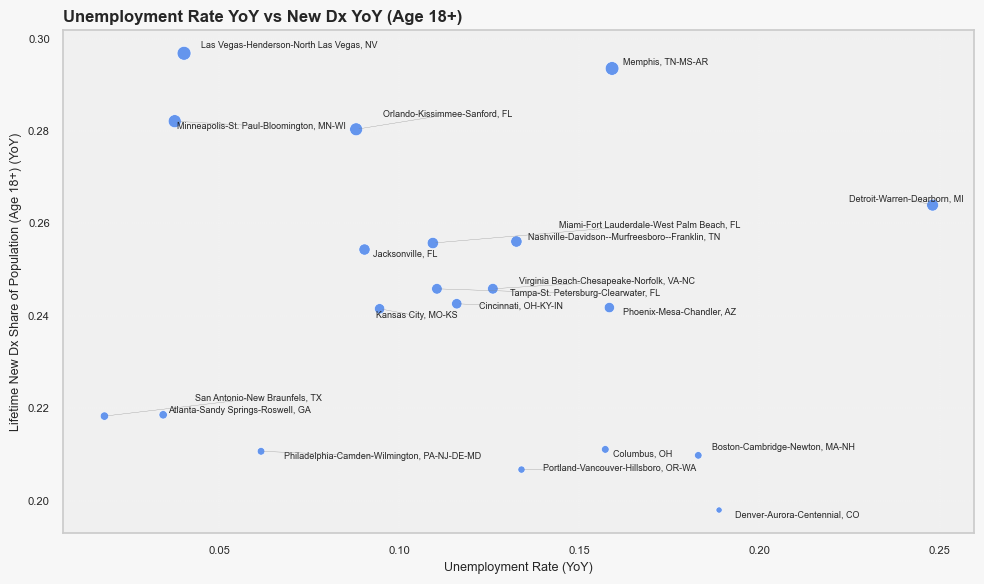

In [836]:
# Unemployment Rate vs New Dx Share of Population (Age 18+)
df_top = df_all_yoy.copy()
df_top['metric'] = df_top['new_dx_yoy']

# basic filter
df_top = df_top[df_top['metric'] > 0]
df_top = df_top[df_top['new_dx_TY'] > 50000]
df_top = df_top[df_top['unemployment_rate_yoy'] > 0]

df_top.sort_values(by='unemployment_rate_yoy', ascending=False, inplace=True)

df = df_top.head(20).copy()

plot_scatter(df, title='Unemployment Rate YoY vs New Dx YoY (Age 18+)')


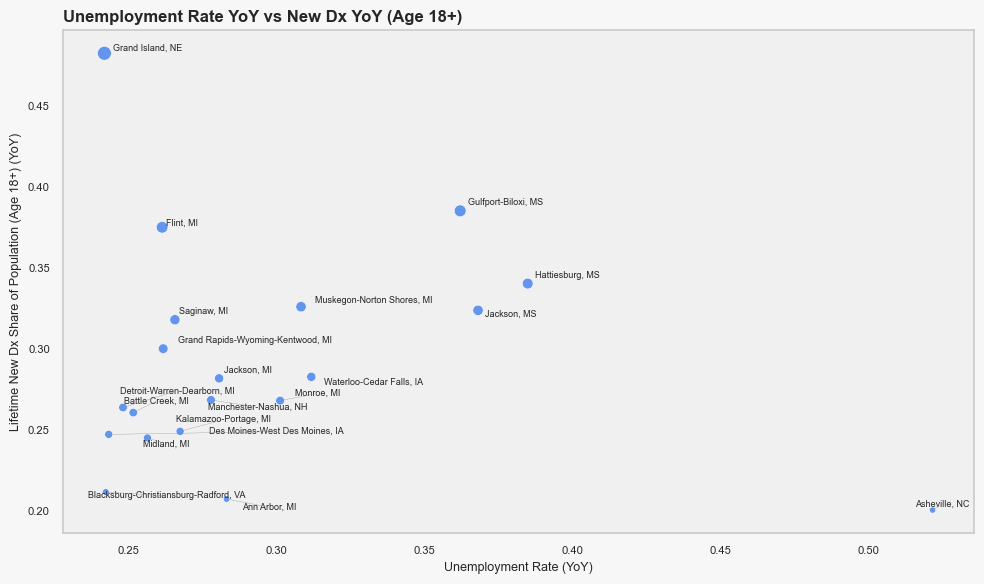

In [837]:
# Unemployment Rate vs New Dx Share of Population (Age 18+)
df_top = df_all_yoy.copy()
df_top['metric'] = df_top['new_dx_yoy']

# basic filter
df_top = df_top[df_top['metric'] > 0]
df_top = df_top[df_top['new_dx_TY'] > 1000]
df_top = df_top[df_top['unemployment_rate_yoy'] > 0]

df_top.sort_values(by='unemployment_rate_yoy', ascending=False, inplace=True)

df = df_top.head(20).copy()

plot_scatter(df, title='Unemployment Rate YoY vs New Dx YoY (Age 18+)')


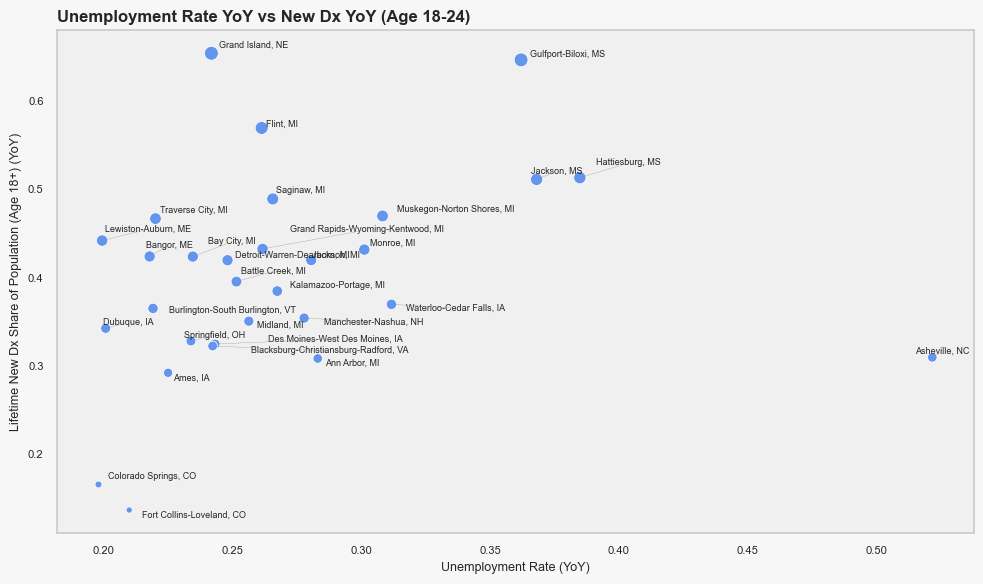

In [839]:
# Unemployment Rate vs New Dx Share of Population (Age 18+)
df_top = df_all_yoy.copy()
df_top['metric'] = df_top['new_dx_18_to_24_yoy']

# basic filter
df_top = df_top[df_top['metric'] > 0]
df_top = df_top[df_top['new_dx_TY'] > 1000]
df_top = df_top[df_top['unemployment_rate_yoy'] > 0]

df_top.sort_values(by='unemployment_rate_yoy', ascending=False, inplace=True)

df = df_top.head(30).copy()

plot_scatter(df, title='Unemployment Rate YoY vs New Dx YoY (Age 18-24)')


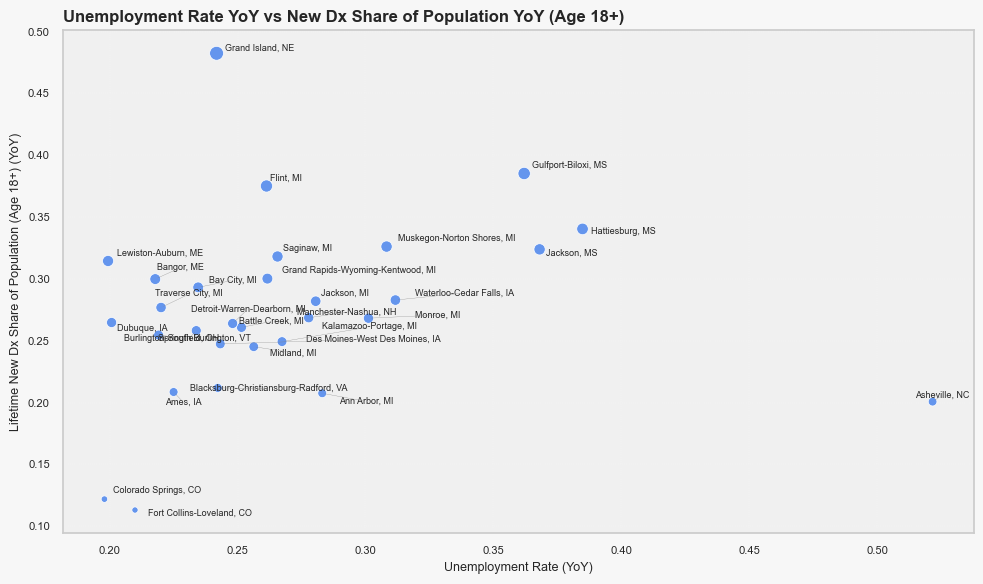

In [840]:
# Unemployment Rate vs New Dx Share of Population (Age 18+)
df_top = df_all_yoy.copy()
df_top['metric'] = df_top['share_of_18plus_yoy']

# basic filter
df_top = df_top[df_top['metric'] > 0]
df_top = df_top[df_top['new_dx_TY'] > 1000]
df_top = df_top[df_top['unemployment_rate_yoy'] > 0]

df_top.sort_values(by='unemployment_rate_yoy', ascending=False, inplace=True)

df = df_top.head(30).copy()

plot_scatter(df, title='Unemployment Rate YoY vs New Dx Share of Population YoY (Age 18+)')


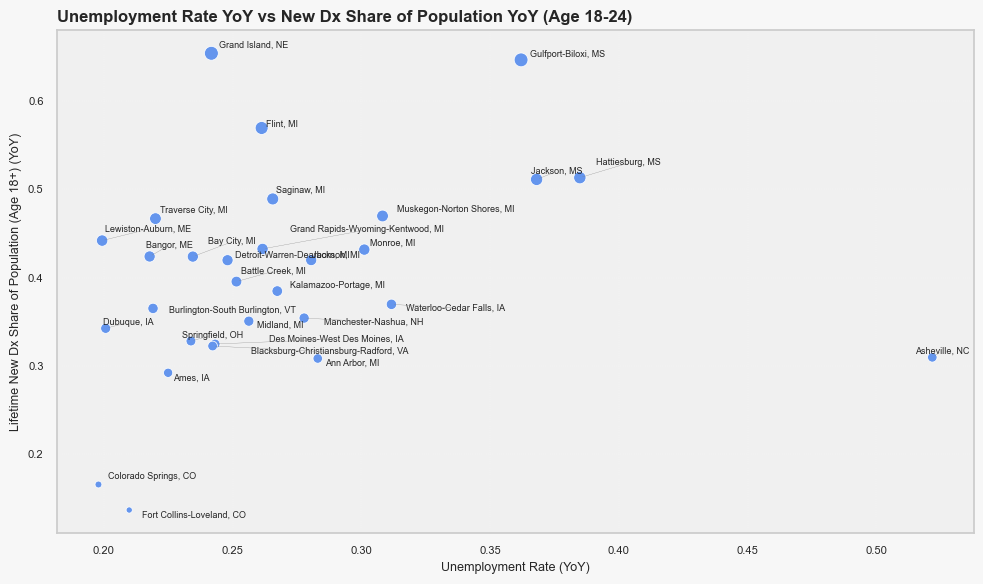

In [841]:
# Unemployment Rate vs New Dx Share of Population (Age 18+)
df_top = df_all_yoy.copy()
df_top['metric'] = df_top['18to24_share_of_18to24_yoy']

# basic filter
df_top = df_top[df_top['metric'] > 0]
df_top = df_top[df_top['new_dx_TY'] > 1000]
df_top = df_top[df_top['unemployment_rate_yoy'] > 0]

df_top.sort_values(by='unemployment_rate_yoy', ascending=False, inplace=True)

df = df_top.head(30).copy()

plot_scatter(df, title='Unemployment Rate YoY vs New Dx Share of Population YoY (Age 18-24)')


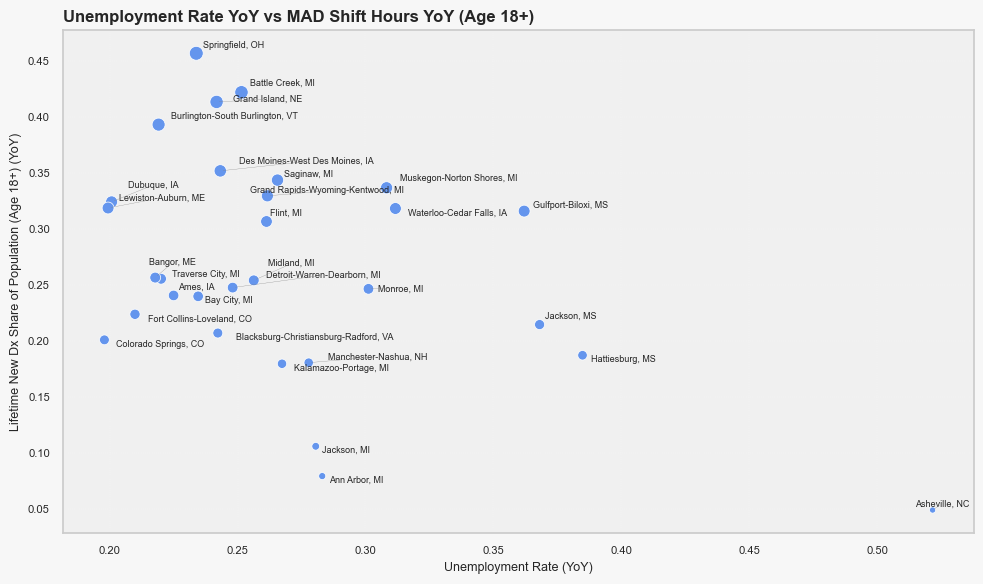

In [842]:
# Unemployment Rate vs New Dx Share of Population (Age 18+)
df_top = df_all_yoy.copy()
df_top['metric'] = df_top['total_shift_hours_yoy']

# basic filter
df_top = df_top[df_top['metric'] > 0]
df_top = df_top[df_top['new_dx_TY'] > 1000]
df_top = df_top[df_top['unemployment_rate_yoy'] > 0]

df_top.sort_values(by='unemployment_rate_yoy', ascending=False, inplace=True)

df = df_top.head(30).copy()

plot_scatter(df, title='Unemployment Rate YoY vs MAD Shift Hours YoY (Age 18+)')


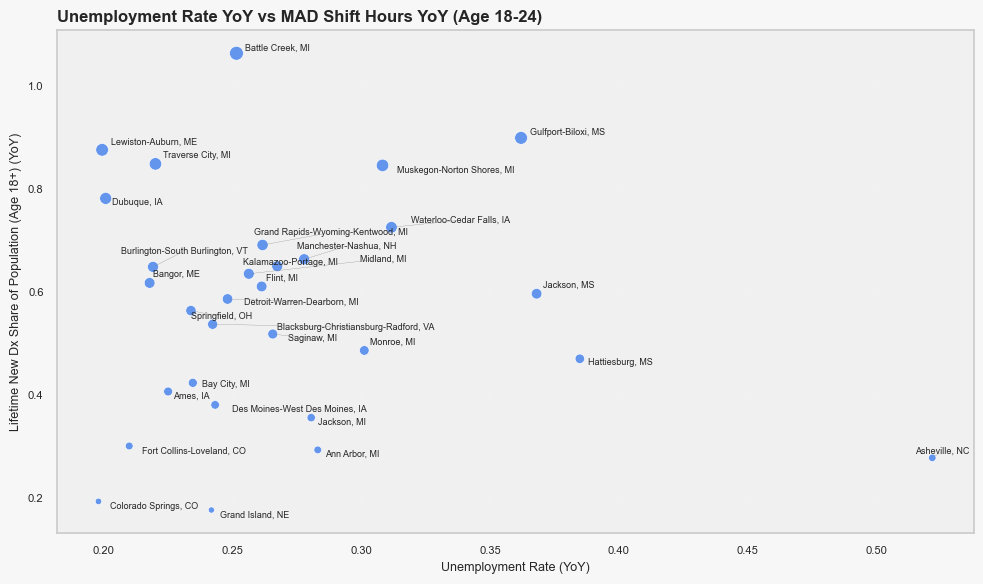

In [843]:
# Unemployment Rate vs New Dx Share of Population (Age 18+)
df_top = df_all_yoy.copy()
df_top['metric'] = df_top['total_shift_hours_18_to_24_yoy']

# basic filter
df_top = df_top[df_top['metric'] > 0]
df_top = df_top[df_top['new_dx_TY'] > 1000]
df_top = df_top[df_top['unemployment_rate_yoy'] > 0]

df_top.sort_values(by='unemployment_rate_yoy', ascending=False, inplace=True)

df = df_top.head(30).copy()

plot_scatter(df, title='Unemployment Rate YoY vs MAD Shift Hours YoY (Age 18-24)')


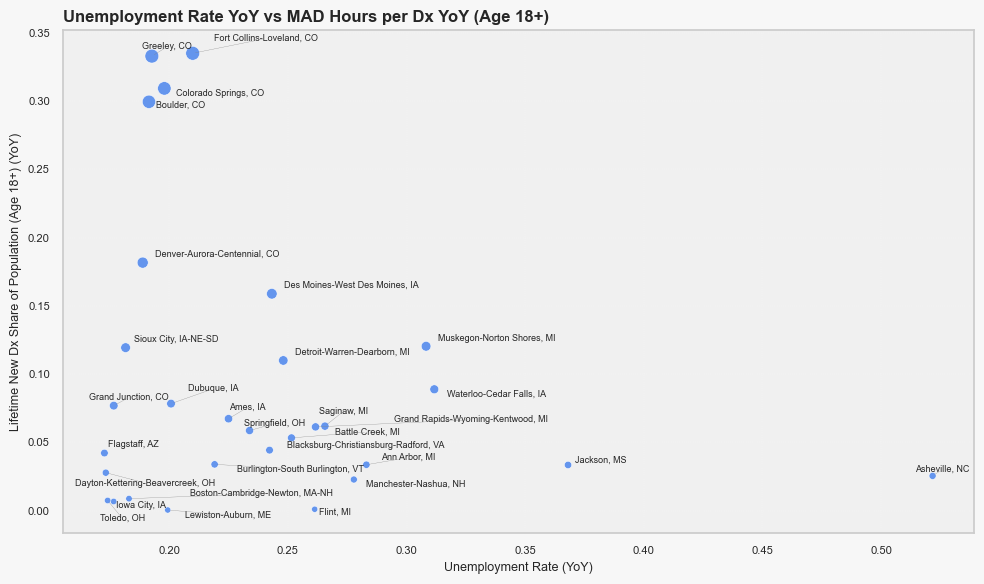

In [844]:
# Unemployment Rate vs New Dx Share of Population (Age 18+)
df_top = df_all_yoy.copy()
df_top['metric'] = df_top['hours_per_dx_yoy']

# basic filter
df_top = df_top[df_top['metric'] > 0]
df_top = df_top[df_top['new_dx_TY'] > 1000]
df_top = df_top[df_top['unemployment_rate_yoy'] > 0]

df_top.sort_values(by='unemployment_rate_yoy', ascending=False, inplace=True)

df = df_top.head(30).copy()

plot_scatter(df, title='Unemployment Rate YoY vs MAD Hours per Dx YoY (Age 18+)')


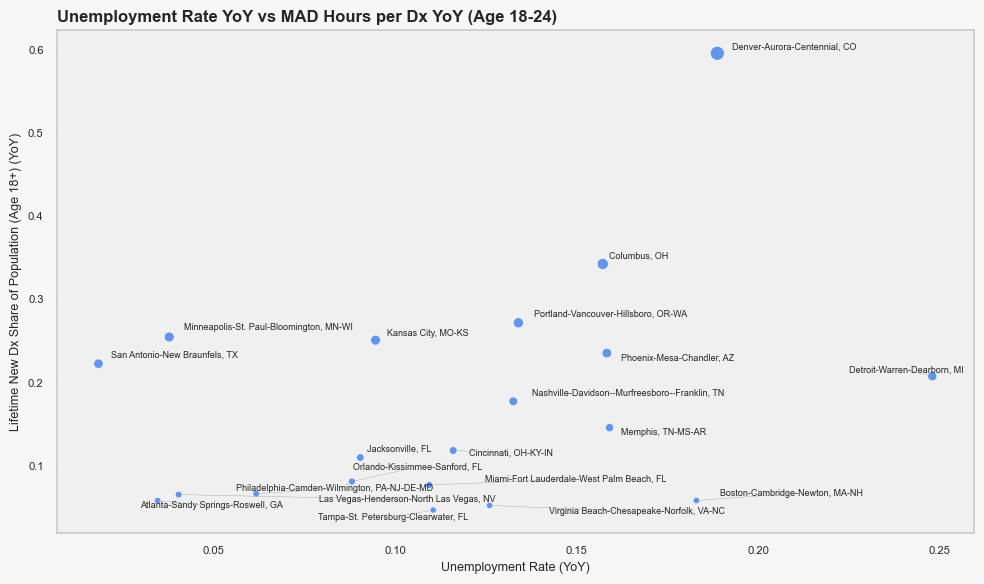

In [851]:
# Unemployment Rate vs New Dx Share of Population (Age 18+)
df_top = df_all_yoy.copy()
df_top['metric'] = df_top['hours_per_dx_18_to_24_yoy']

# basic filter
df_top = df_top[df_top['metric'] > 0]
df_top = df_top[df_top['new_dx_TY'] > 50000]
df_top = df_top[df_top['unemployment_rate_yoy'] > 0]

df_top.sort_values(by='unemployment_rate_yoy', ascending=False, inplace=True)

df = df_top.head(20).copy()

plot_scatter(df, title='Unemployment Rate YoY vs MAD Hours per Dx YoY (Age 18-24)')


In [795]:
def plot_time_series(df, metric):
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates

    # Loop through each market
    for market in df['msa_title'].unique():
        market_df = df[df['msa_title'] == market]

        fig, ax1 = plt.subplots(figsize=(12, 6))
        fig.patch.set_facecolor('#f7f7f7')  # background color

        # === Plot 1: Metric ===
        color1 = '#1f77b4'
        ax1.set_xlabel("Month", fontsize=11)
        ax1.set_ylabel(metric, color=color1, fontsize=11)
        ax1.plot(
            market_df['applied_month'],
            market_df[metric],
            color=color1,
            label=f"{metric}",
            linewidth=2.2,
            marker='o',
            markersize=4
        )
        ax1.tick_params(axis='y', labelcolor=color1, labelsize=9)
        ax1.tick_params(axis='x', labelsize=9)
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        plt.xticks(rotation=45)
        ax1.grid(True, linestyle="--", linewidth=0.4, alpha=0.4)

        # === Plot 2: Unemployment Rate ===
        ax2 = ax1.twinx()
        color2 = '#d62728'
        ax2.set_ylabel("Unemployment Rate", color=color2, fontsize=11)
        ax2.plot(
            market_df['applied_month'],
            market_df['unemployment_rate'],
            color=color2,
            label="Unemployment Rate",
            linewidth=2.2,
            marker='s',
            markersize=4
        )
        ax2.tick_params(axis='y', labelcolor=color2, labelsize=9)

        # === Combine Legends ===
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(
            lines_1 + lines_2,
            labels_1 + labels_2,
            loc='upper left',
            frameon=True,
            fontsize=9
        )

        # === Dynamic Title ===
        plt.title(
            f"{market} — {metric} vs Unemployment Rate Over Time",
            fontsize=13,
            weight='bold',
            loc='left'
        )
        plt.tight_layout()
        plt.show()


In [802]:
# df = df_msa_saturation_ur.copy()
# top_10 = df_top.head(10)
# selected_msa = df[df['msa_title'].isin(top_10['market'].values.tolist())]

# # Call function with the metric column you want
# plot_time_series(selected_msa, metric='dx_cnt_18plus')


#### Young Dx